### Telco Customer Churn

In this project we will use machine learning to predict customer churn.

Churn prediction is the basis for a customer retention strategy.

If we can identify the customers who are likely to churn we can offer them an incentive to stay.

#### Column Metadata

Each row in the dataset represents a customer, each column contains the customer’s attributes:

| Feature | Description
| :------------ | :----------- | 
| Customer ID   | The customer ID |
| gender        | Male or Female  |
| SeniorCitizen | Senior Citizen or not (1, 0) |
| Partner       | Has a partner or not (Yes, No) |
| Dependents    | Has dependents or not (Yes, No) |
| tenure        | Number of months the customer has stayed with the company |
| PhoneService  | Has a phone service or not (Yes, No) |
| MultipleLines | Has multiple lines or not (Yes, No, No phone service) |
| InternetService | Type of internet service (DSL, Fiber optic, No) |
| OnlineSecurity | Has online security or not (Yes, No, No internet service) |
| OnlineBackup   | Has online backup or not (Yes, No, No internet service) |
| DeviceProtection | Has device protection or not (Yes, No, No internet service) |
| TechSupport      | Has tech support or not (Yes, No, No internet service) |
| StreamingTV      | Has streaming TV or not (Yes, No, No internet service) |
| StreamingMovies  | Has streaming movies or not (Yes, No, No internet service) |
| Contract         | The contract term (Month-to-month, One year, Two year) |
| PaperlessBilling | Has paperless billing or not (Yes, No) |
| PaymentMethod    | Customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges   | The amount charged to the customer each month |
| TotalCharges     | The total amount charged to the customer |
| Churn            | Whether the customer churned or not (Yes or No) |


The raw data contains 7043 rows (customers) and 21 columns (features).

We will use 'Churn' as the target variable in the machine learning model and predict it using the other information.

In [1]:
# Imports
# install it if you do not have
# pip install kagglehub
import kagglehub
import os, shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    mutual_info_score,
    confusion_matrix,
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


C:\Users\sysadmin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the Data

In [2]:
# Download latest version
csv_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
path_download = kagglehub.dataset_download("blastchar/telco-customer-churn",force_download=True)
file_download = os.path.join(path_download, csv_name)

#-------------------------------------------------------------------------------------------------------
# Instead of saving to Google Drive directly, let's save to a local Colab directory first
#-------------------------------------------------------------------------------------------------------
path_destination = "dataset"
file_destination = os.path.join(path_destination, csv_name)

os.makedirs(path_destination,exist_ok=True)

# Check if the destination file already exists
if os.path.exists(file_destination):
    os.remove(file_destination)

# Use shutil.copyfile instead of shutil.move because the source is on a read-only file system
shutil.copyfile(file_download,file_destination)

df_rawtelco = pd.read_csv(file_destination)



100%|███████████████████████████████████████████████████████████████████████████████| 172k/172k [00:00<00:00, 3.06MB/s]

Extracting files...


In [3]:
df_rawtelco.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


#### Prepare and Clean the Data

In [4]:
## Exploring and understanding the data ##

print("Shape:",df_rawtelco.shape)
df_rawtelco.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

The numeric columns are SeniorCitizen, tenure, MonthlyCharges. SeniorCitizen is typed as an integer because its values are 0 or 1. TotalCharges is incorrectly identified as 'object', but it should be a float not a string. The reason is because in some cases TotalCharges contains a space.

In [5]:
df_rawtelco.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
## missing values

df_rawtelco.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Data cleaning

# keep the original data
df_cleantelco = df_rawtelco.copy(deep = True)

In [8]:
# Make all strings lowercase and replace spaces with underscores
string_columns = df_cleantelco.select_dtypes(include=['object']).columns 
for col_name in string_columns:
    df_cleantelco[col_name] = df_cleantelco[col_name].str.lower().str.replace(' ', '_') 

In [9]:
## Total charges - Replace spaces with np.nan and converto to numeric datatype.
 
df_cleantelco["TotalCharges"] = pd.to_numeric(df_cleantelco["TotalCharges"], errors='coerce')

df_cleantelco["TotalCharges"].isna().sum()

np.int64(11)

In [10]:
## delete rows with totalcharges null - small number of rows (11 only)

df_cleantelco = df_cleantelco.dropna(subset = ["TotalCharges"])
df_cleantelco.shape


(7032, 21)

In [11]:
# drop column customerid
df_cleantelco = df_cleantelco.drop(columns=["customerID"])

# convert Churn to binary
df_cleantelco["Churn"] = (df_cleantelco["Churn"] == 'yes').astype(int)

df_cleantelco["Churn"].value_counts()


Churn
0    5163
1    1869
Name: count, dtype: int64

In [12]:
df_cleantelco.head(5).T

,0,1,2,3,4
gender,female,male,male,male,female
SeniorCitizen,0,0,0,0,0
Partner,yes,no,no,no,no
Dependents,no,no,no,no,no
tenure,1,34,2,45,2
PhoneService,no,yes,yes,no,yes
MultipleLines,no_phone_service,no,no,no_phone_service,no
InternetService,dsl,dsl,dsl,dsl,fiber_optic
OnlineSecurity,no,yes,yes,yes,no
OnlineBackup,yes,no,yes,no,no


#### Exploratory Data Analysis

In [13]:
# Check the distribution of values in the target variable 

df_cleantelco["Churn"].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [14]:
# Calculate the churn rate 
churn_rate = round(df_cleantelco['Churn'].mean(), 2)
print(f'Churn rate: {churn_rate}') 

Churn rate: 0.27


The churn rate in the data is 0.27 (27%). From this we can see that the dataset is imbalanced. Approximately two thirds of the customers did not churn and one third of customers churned. 

##### Risk Analysis
We want to understand how each feature affects the risk of churning. We can peform risk analysis by looking at the difference between customer groups and the overall churn rate. If the difference between the group rate and the global rate is small then the risk ratio will be close to 1.0. Customers in this group are no more and no less likely to churn than the rest of the population. If the risk ratio is lower than 1.0 then the customers in this group are less likely to churn. On the other hand, if the risk ratio is greater than 1.0 then the customers in the group are more likely to churn (they are more risky).

In [15]:
# We want to examine categorical and numerical variables separately.

# Create two lists, one for categorical features and one for numerical.
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Target variable
dep_var = ['Churn']


In [16]:
# Determine risk ratio for gender
female_churn_rate = df_cleantelco[df_cleantelco['gender'] == 'female'].Churn.mean()
male_churn_rate = df_cleantelco[df_cleantelco['gender'] == 'male'].Churn.mean()

print(f'female churn rate: {round(female_churn_rate, 2)} (risk of churning: {round(female_churn_rate / churn_rate, 2)})')
print(f'male churn rate: {round(male_churn_rate, 2)} (risk of churning: {round(male_churn_rate / churn_rate, 2)})') 

female churn rate: 0.27 (risk of churning: 1.0)
male churn rate: 0.26 (risk of churning: 0.97)


The risk of churning when gender = female is 1.0 and the risk of churning when gender = male is 0.97. Because these groups have a risk ratio very close or the same as the overall churn rate they are not strong indicators of churn. 

In [17]:
# Determine risk for customers who have partners and those who don't
partner_yes_churn_rate = df_cleantelco[df_cleantelco['Partner'] == 'yes'].Churn.mean()
partner_no_churn_rate = df_cleantelco[df_cleantelco['Partner'] == 'no'].Churn.mean()

print(f'Has partner churn rate: {round(partner_yes_churn_rate, 2)} (risk of churning: {round(partner_yes_churn_rate / churn_rate, 2)})')
print(f'No partner churn rate: {round(partner_no_churn_rate, 2)} (risk of churning: {round(partner_no_churn_rate / churn_rate, 2)})')

Has partner churn rate: 0.2 (risk of churning: 0.73)
No partner churn rate: 0.33 (risk of churning: 1.22)


The risk ratio for customers without partners is above 1.0. This indicates that customers without partners are more likely to churn than those with partners.

In [18]:
# compute the risk for customer groups 
high_risk = []
for col in categorical_vars: 
    df_group = df_cleantelco.groupby(by=col, as_index=False).Churn.agg(['mean']) 
    df_group['diff'] = df_group['mean'] - churn_rate
    df_group['risk'] = df_group['mean'] /  churn_rate
    # print those groups with a risk ratio greater than 1.0 
    for tup in list(df_group.itertuples(index=False, name=col)):
        if tup[3] > 1.0:
            high_risk.append(tup._asdict())

sorted_results = sorted(high_risk, key=lambda i: i["risk"], reverse=True)
                           
for i in sorted_results:
    print(i) 
    


{'PaymentMethod': 'electronic_check', 'mean': 0.4528541226215645, 'diff': 0.18285412262156447, 'risk': 1.6772374911909795}
{'Contract': 'month-to-month', 'mean': 0.4270967741935484, 'diff': 0.1570967741935484, 'risk': 1.5818399044205496}
{'InternetService': 'fiber_optic', 'mean': 0.4189276485788114, 'diff': 0.14892764857881136, 'risk': 1.5515838836252271}
{'OnlineSecurity': 'no', 'mean': 0.4177866742922505, 'diff': 0.1477866742922505, 'risk': 1.5473580529342612}
{'SeniorCitizen': 1, 'mean': 0.4168126094570928, 'diff': 0.1468126094570928, 'risk': 1.54375040539664}
{'TechSupport': 'no', 'mean': 0.41647465437788017, 'diff': 0.14647465437788015, 'risk': 1.5424987199180746}
{'OnlineBackup': 'no', 'mean': 0.39941690962099125, 'diff': 0.12941690962099123, 'risk': 1.4793218874851526}
{'DeviceProtection': 'no', 'mean': 0.3914027149321267, 'diff': 0.12140271493212668, 'risk': 1.4496396849338025}
{'StreamingMovies': 'no', 'mean': 0.33728874505573536, 'diff': 0.06728874505573534, 'risk': 1.2492175

These are the customer groups with the highest risk of churn as measured by risk ratio (group churn rate / overall churn rate). When the payment method is by electronic check the risk of churn is highest ( 1.67 ). When the contract is month to month or the internet service is fiber optic the risk of churn is high.

#### Feature Importance

Mutual information is used to measure the mutual dependency between two categorical variables. If the mutual information between a categorical variable and the target variable is high the two variables depend on one another and the categorical variable will be useful for predicting the target variable. On the other hand, if the mutual information between a categorical variable and the target variable is low the two variables are independent of each other and the categorical variable will not be useful for predicting the target variable. Here we use the mutual information score to assess the importance of the categorical variables for predicting churn.

In [19]:
def calculate_mi(series): 
    return mutual_info_score(series, df_cleantelco.Churn) 
 
df_mi = df_cleantelco[categorical_vars].apply(calculate_mi) 
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI') 
df_mi

,MI
Contract,0.098182
OnlineSecurity,0.064528
TechSupport,0.062873
InternetService,0.055394
OnlineBackup,0.046659
PaymentMethod,0.044423
DeviceProtection,0.043784
StreamingMovies,0.031918
StreamingTV,0.031803
PaperlessBilling,0.019119


Contract, OnlineSecurity and TechSupport are among the most important features for predicting churn and MultipleLines, PhoneService and gender are the least important.

#### Correlation Analysis

Mutual information can only be used on categorical variables. In order to assess the importance of the numerical variables we can use the correlation coefficient.

In [20]:
df_cleantelco[numeric_vars].corrwith(df_cleantelco.Churn)

tenure           -0.354049
MonthlyCharges    0.192858
TotalCharges     -0.199484
dtype: float64

Tenure has a negative correlation with the target variable. This means that when tenure goes up the target variable goes down. Customers who have been with the company longer have a lower churn rate. MonthlyCharges has a positive correlation with the target variable. This means that as monthly charges increase the churn rate also increases. TotalCharges has a negative correlation. The more customers have paid in total the less likely they are to leave. 

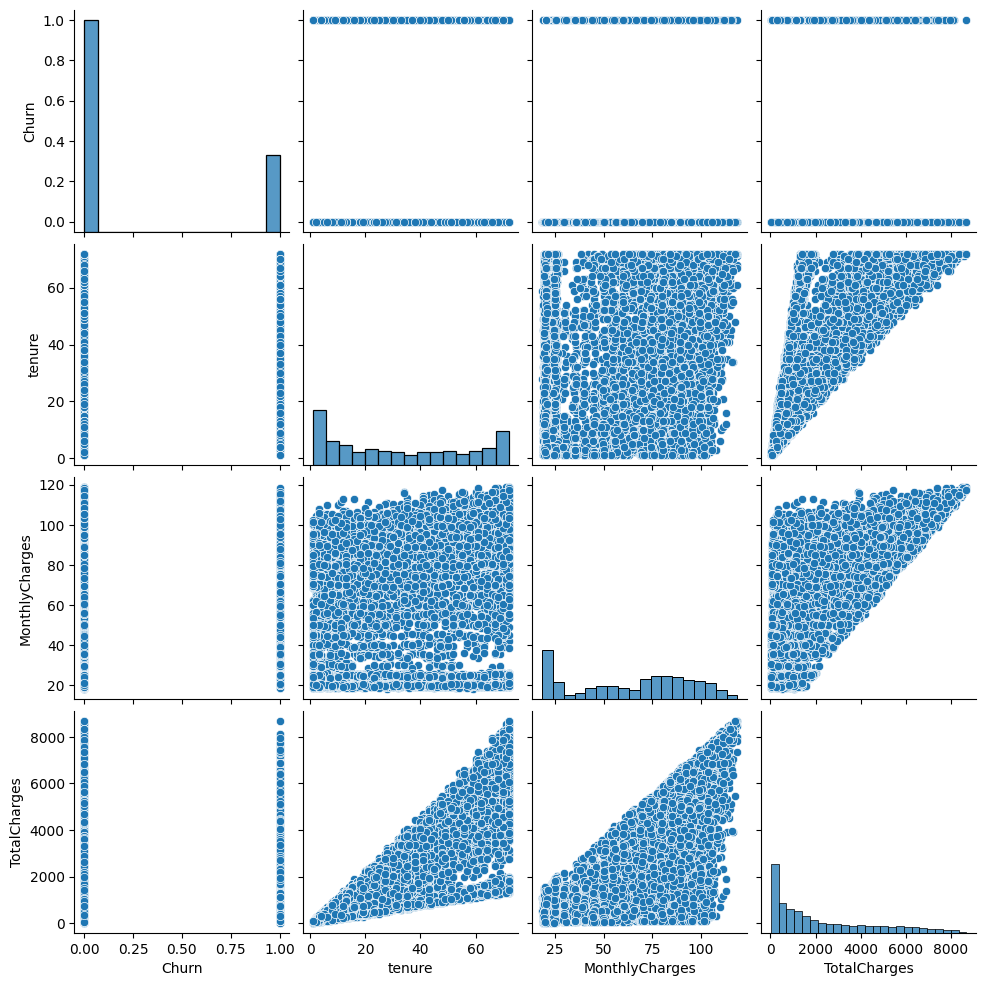

In [21]:
sns.pairplot(data=df_cleantelco.loc[:, ['Churn'] + numeric_vars])
plt.show()

### **Encode Categorical Features:**
Generally, it is required to apply One-Hot Encoding (or another suitable encoding) to the categorical features before applying machine learning models like Logistic Regression, Random Forest Classifier, and Gradient Boost. Here's why:

*   **Logistic Regression:** This is a linear model and requires numerical input. Categorical variables must be converted into a numerical format for the model to process them correctly.

*   **Random Forest Classifier:** While tree-based models can sometimes implicitly handle categorical data, many implementations (including scikit-learn's Random Forest) still expect numerical input. One-Hot Encoding prevents the model from assuming an ordinal relationship between categories.
*   **Gradient Boost (e.g., XGBoost, LightGBM):** Similar to Random Forest, these models often perform best or require numerical input. Some advanced Gradient Boosting libraries like CatBoost can handle categorical features natively, but for more common implementations like XGBoost or LightGBM, encoding is usually necessary.

One-Hot Encoding creates new binary (0 or 1) columns for each category, which is a robust way to represent nominal categorical data without implying any false ordinality.

In [22]:
################################################
# Categorical Transformer - one hot encoder
################################################
# For our categorical features, we can use one-hot encoding to represent the different categories numerically.
# With this approach, each unique value of a feature is given its own column. Thus, the data will be encoded with a "1"
# in the column which matches the value and a "0" in every other column.
# The use of multiple columns via one-hot encoding ensures that our categorical values are not treated as ordinal data.

# "Categorical Encoder" Transformer - (name, transformer) tuple
# Removed the intermediate Pipeline and directly use OneHotEncoder in the transformer list for ColumnTransformer.
cat_transformers = [('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_vars)]

In [23]:
################################################
# No Transformation of Numeric independent variables
################################################

#from sklearn.pipeline import Pipeline

# ColumnTransformer
ct = ColumnTransformer(transformers=cat_transformers + [('passthrough', 'passthrough', numeric_vars)])
ct.fit(df_cleantelco[categorical_vars + numeric_vars])
X = ct.transform(df_cleantelco[categorical_vars + numeric_vars])
# We know from our exploration that the dependent variable 'Churn' does not have any missing values.
y = df_cleantelco['Churn'].values

In [24]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (7032, 46)
Shape of y: (7032,)


### **Train / Test Split:**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation and splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data preparation and splitting complete.
X_train shape: (5625, 46)
X_test shape: (1407, 46)
y_train shape: (5625,)
y_test shape: (1407,)


### **Dimension Reduction:**

PCA doesn't directly 'retain' original columns. Instead, it transforms data into a new set of dimensions called principal components, which are linear combinations of original features.

To understand which original columns contribute most to these principal components, examine the components_ attribute of the fitted PCA object. This attribute shows the 'loadings' or 'weights' of each original feature on each principal component.

Since the PCA retained only one component, we'll look at how the original 39 features contribute to this single component. First, look at the the full list of feature names generated from the ColumnTransformer "ct", created as a result of One-Hot Encoding. And then look at the loadings to be able to interpret which original features are most influential in that principal component.

The output lists the 'loadings' of each of the original features onto the single principal component that PCA retained. These loadings indicate the correlation between the original features and the principal component.

From the sorted list, it's clear that "**TotalCharges**" has an extremely high absolute loading (nearly 1.0), which means the first principal component (PC1) is almost entirely explained by the TotalCharges feature. The other features have comparatively very small loadings, indicating they contribute much less to this principal component.

In essence, the data's primary variance, as captured by this single principal component, is overwhelmingly driven by the "**TotalCharges**" variable.



In [26]:
# Apply PCA for Dimension Reduction:
# The task requires applying PCA to the training and test datasets.
# The first step is to import the `PCA` class from `sklearn.decomposition`, instantiate it with the specified parameters,
# fit it to the training data, and then transform both the training and test datasets.


# Instantiate PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on the training data
pca.fit(X_train)

# Transform both training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original training data shape: {X_train.shape}")
print(f"Reduced training data shape: {X_train_pca.shape}")
print(f"Original test data shape: {X_test.shape}")
print(f"Reduced test data shape: {X_test_pca.shape}")
print(f"Number of components retained: {pca.n_components_}")

Original training data shape: (5625, 46)
Reduced training data shape: (5625, 1)
Original test data shape: (1407, 46)
Reduced test data shape: (1407, 1)
Number of components retained: 1


In [27]:
# Get full list of feature names from
# the ColumnTransformer "ct", created as a result of One-Hot Encoding.
def get_feature_names(column_transformer):
    output_features = []
    for name, estimator, features in column_transformer.transformers_:
        if name == 'passthrough':
            output_features.extend(features)
        elif hasattr(estimator, 'get_feature_names_out'):
            output_features.extend(estimator.get_feature_names_out(features))
        else:
            output_features.extend(features) # Fallback for estimators without get_feature_names_out
    return output_features

feature_names = get_feature_names(ct)

print("Original feature names after One-Hot Encoding and passthrough:")
print(feature_names)

Original feature names after One-Hot Encoding and passthrough:
['gender_female', 'gender_male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_no', 'Partner_yes', 'Dependents_no', 'Dependents_yes', 'PhoneService_no', 'PhoneService_yes', 'MultipleLines_no', 'MultipleLines_no_phone_service', 'MultipleLines_yes', 'InternetService_dsl', 'InternetService_fiber_optic', 'InternetService_no', 'OnlineSecurity_no', 'OnlineSecurity_no_internet_service', 'OnlineSecurity_yes', 'OnlineBackup_no', 'OnlineBackup_no_internet_service', 'OnlineBackup_yes', 'DeviceProtection_no', 'DeviceProtection_no_internet_service', 'DeviceProtection_yes', 'TechSupport_no', 'TechSupport_no_internet_service', 'TechSupport_yes', 'StreamingTV_no', 'StreamingTV_no_internet_service', 'StreamingTV_yes', 'StreamingMovies_no', 'StreamingMovies_no_internet_service', 'StreamingMovies_yes', 'Contract_month-to-month', 'Contract_one_year', 'Contract_two_year', 'PaperlessBilling_no', 'PaperlessBilling_yes', 'PaymentMethod_bank_trans

In [28]:
# Display the loadings of the single principal component
# The pca.components_ array has shape (n_components, n_features)
# Since n_components_ is 1, pca.components_[0] will give the loadings for
# the first (and only) principal component.

if pca.n_components_ > 0:
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)
    # Sort by absolute value to see the most influential features
    print("\nLoadings of original features on the first Principal Component (sorted by absolute value):")
    display(loadings['PC1'].abs().sort_values(ascending=False))
else:
    print("No principal components were retained.")


Loadings of original features on the first Principal Component (sorted by absolute value):


TotalCharges                               9.999224e-01
tenure                                     8.939628e-03
MonthlyCharges                             8.664966e-03
StreamingMovies_yes                        1.120580e-04
StreamingTV_yes                            1.116870e-04
DeviceProtection_yes                       1.092643e-04
OnlineBackup_yes                           1.060784e-04
MultipleLines_yes                          1.008572e-04
Contract_month-to-month                    9.916128e-05
TechSupport_yes                            8.754530e-05
MultipleLines_no                           8.594363e-05
OnlineSecurity_yes                         8.330104e-05
InternetService_fiber_optic                7.891504e-05
Partner_yes                                7.021628e-05
Partner_no                                 7.021628e-05
TechSupport_no_internet_service            6.898080e-05
StreamingMovies_no_internet_service        6.898080e-05
DeviceProtection_no_internet_service       6.898

We have successfully completed the data preprocessing, cleaning, one-hot encoding, Train/Test split and dimensionality reduction using PCA. The PCA results indicated that the "**TotalCharges**" feature contributes almost entirely to the single principal component retained.

Now that the data is prepared, the next logical step is to train machine learning models, such as Logistic Regression, Random Forest, or Gradient Boosting, and evaluate their performance on either the PCA-transformed dataset (i.e. X_train_pca, X_test_pca, y_train, y_test) or Untransformed dataset (i.e. X_train, X_test, y_train, y_test).

In [29]:
# compute model metrics
def evaluate_model(model_name, y_true, y_pred, y_proba):
    name = model_name
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc = roc_auc_score(y_true, y_proba)
    tup = (name, acc, prec, rec, f1, fpr, tpr, roc) 

    return  pd.DataFrame([tup], columns=["Name", "Accuracy", "Precision", "Recall", "F1", "FPR", "TPR", "ROC_AUC"])

### Machine learning for classification

#### Logistic Regression

In [30]:
lr_model = LogisticRegression(max_iter=5625, random_state=42)
lr_model.fit(X_train, y_train)
 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,5625
,multi_class,'deprecated'


In [31]:
# To get the probabilities we use the predict_proba of the model. The result is a matrix with two columns. 
# The first column contains the probability that the target variable is zero (the client won't churn). The 
# second column contains the probability that the target is positive (the client will churn). 
y_proba = lr_model.predict_proba(X_test)[:, 1]
y_proba.shape 

(1407,)

In [32]:
# Convert model probabilities into class predictions

# If the probability for a customer is higher than a threshold, we predict churn, otherwise not
# churn. We will use 0.5 as the threshold:
churn_pred = (y_proba >= 0.5).astype(int) 

In [33]:
# compute the accuracy score for the model
accuracy = accuracy_score(y_test, churn_pred)

print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.79


In [34]:
# loop over different thresholds and check which one gives the best accuracy
thresholds = np.linspace(0, 1, 11)
accuracies = []

for t in thresholds:
    churn = y_proba >= t
    acc = accuracy_score(y_test, churn)
    print('%0.2f %0.3f' % (t, acc))
    accuracies.append(acc)

0.00 0.266
0.10 0.608
0.20 0.682
0.30 0.755
0.40 0.782
0.50 0.788
0.60 0.790
0.70 0.778
0.80 0.738
0.90 0.734
1.00 0.734


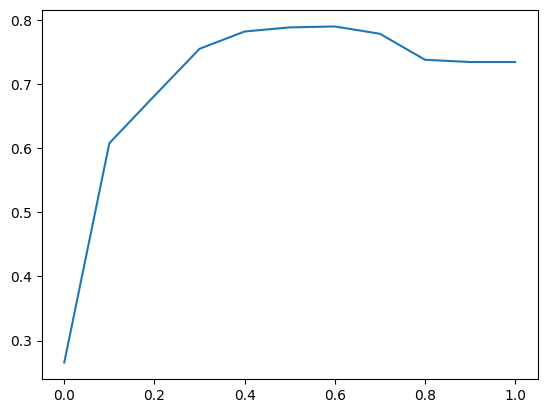

In [35]:
plt.plot(thresholds, accuracies)

If a prediction is higher than the threshold we predict 'churn', otherwise we predict 'no churn'. The best threshold is 0.6, and the best accuracy we can achieve for the model is 0.79 (79%).

In [36]:
# Calculate a confusion matrix to get a detailed breakdown of the model’s performance compared to the actual values
conf_matrix = confusion_matrix(y_test, churn_pred)
print(f"Confusion Matrix: \n{conf_matrix}") 

# The confusion matrix contains four key components for binary classification:

# True positives (tp): The number of correctly predicted positive observations (true and predicted labels equal 1)
# True negatives (tn): The number of correctly predicted negative observations (true and predicted labels equal 0)
# False positives (fp): The number of incorrectly predicted positive observations (true labels equal 0, predicted labels equal 1)
# False negatives (fn): The number of incorrectly predicted negative observations (true labels equal 1, predicted labels equal 0)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

print (f"tp: {tp}")
print (f"tn: {tn}")
print (f"fp: {fp}")
print (f"fn: {fn}")


Confusion Matrix: 
[[916 117]
 [181 193]]
tp: 193
tn: 916
fp: 117
fn: 181


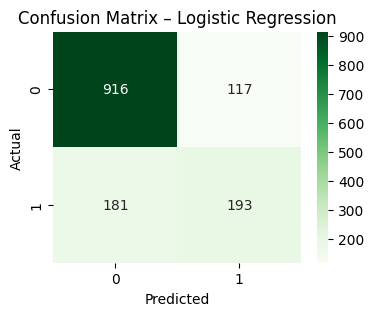

In [37]:
# Show confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, churn_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens") 
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
# calculate model precision
# precision tells us how many customers actually churned out of all those we predicted would churn (tp + fp) ?
 
P = tp / (tp + fp) 
print(f"Precision: {round(P, 3)}")

Precision: 0.623


In [39]:
# calculate recall
# recall tells us the percentage of customers correctly predicted as churning out of all churned customers (tp + fn) 
R = tp / (tp + fn) 
print(f"Recall: {round(R, 3)}")

Recall: 0.516


For the Logistic Regression model the precision is 62% and the recall is 52%. The precision of 62% means that 62% of the customers we identified as going to churn actually churned (true positives) whereas 38% of the customers we identified as going to churn did not churn (false positives). The recall of 52% means that we identified only 52% of all churning users (true positives) and failed to identify the remaining 48% (false negatives).

In [40]:
# Calculate the False Positive Rate (fpr), True Positive Rate (tpr) and the Area Under Curve (auc) and plot 
# a ROC curve for the Logistic Regression Model 

# y_test = true labels (0/1)
# y_proba = predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr,  tpr)  

In [41]:
# Find the best threshold for the ROC curve
# Compute Youden J index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best Threshold:", best_thresh)
print("TPR:", tpr[ix], "FPR:", fpr[ix])

Best Threshold: 0.29032620058199143
TPR: 0.7780748663101604 FPR: 0.2536302032913843


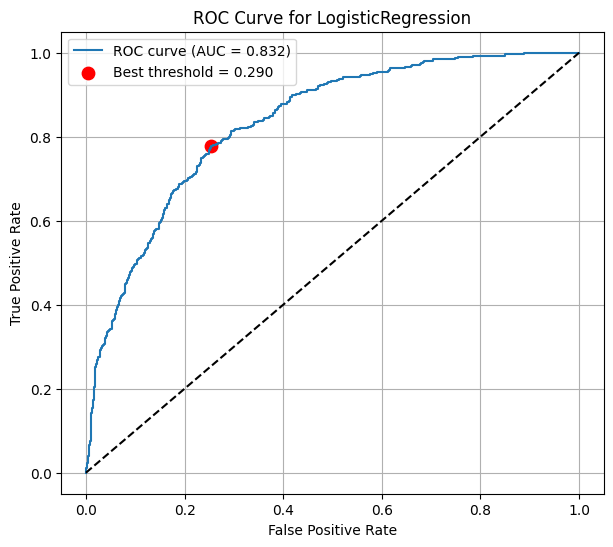

In [42]:
# Plot the ROC curve and mark the best threshold
plt.figure(figsize=(7, 6))

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.3f})')

# Plot the best threshold point
plt.scatter(fpr[ix], tpr[ix], color='red', s=80,
            label=f'Best threshold = {best_thresh:.3f}')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LogisticRegression")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# store model metrics for comparison with other models
lr_metrics = evaluate_model('LogisticRegression', y_test, churn_pred, y_proba)

#### Random Forest

In [44]:
 #Tree-based model: Random Forest

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
# To get the probabilities we use the predict_proba of the model. The result is a matrix with two columns. 
# The first column contains the probability that the target variable is zero (the client won't churn). The 
# second column contains the probability that the target is positive (the client will churn). 
y_proba = rf_model.predict_proba(X_test)[:, 1]
y_proba.shape 

(1407,)

In [46]:
# Convert model probabilities into class predictions

# If the probability for a customer is higher than a threshold, we predict churn, otherwise not
# churn. We will use 0.5 as the threshold:
churn_pred = (y_proba >= 0.5).astype(int) 

In [47]:
# compute the accuracy score for the model
accuracy = accuracy_score(y_test, churn_pred)

print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.78


In [48]:
# loop over different thresholds and check which one gives the best accuracy
thresholds = np.linspace(0, 1, 11)
accuracies = []

for t in thresholds:
    churn = y_proba >= t
    acc = accuracy_score(y_test, churn)
    print('%0.2f %0.3f' % (t, acc))
    accuracies.append(acc)

0.00 0.266
0.10 0.585
0.20 0.682
0.30 0.748
0.40 0.769
0.50 0.785
0.60 0.785
0.70 0.778
0.80 0.761
0.90 0.747
1.00 0.736


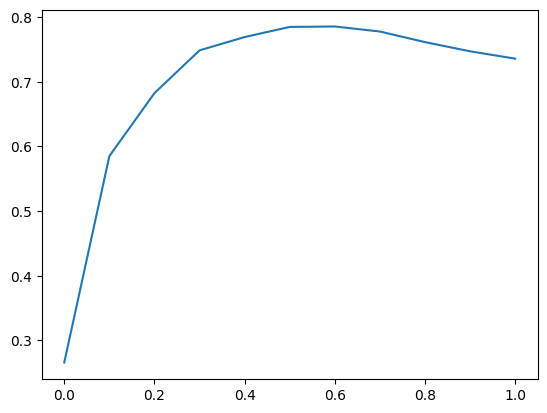

In [49]:
plt.plot(thresholds, accuracies)

If a prediction is higher than the threshold we predict 'churn', otherwise we predict 'no churn'. The best threshold is 0.5, and the best accuracy we can achieve for the model is 0.785 (79%).

In [50]:
# Calculate a confusion matrix to get a detailed breakdown of the model’s performance compared to the actual values
conf_matrix = confusion_matrix(y_test, churn_pred)
print(f"Confusion Matrix: \n{conf_matrix}") 

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

print (f"tp: {tp}")
print (f"tn: {tn}")
print (f"fp: {fp}")
print (f"fn: {fn}")

Confusion Matrix: 
[[928 105]
 [198 176]]
tp: 176
tn: 928
fp: 105
fn: 198


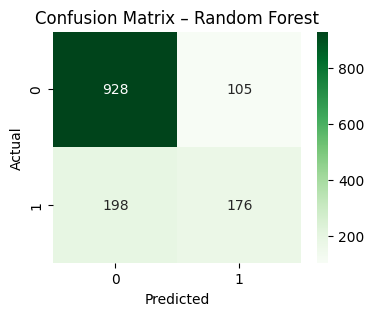

In [51]:
# Show confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, churn_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens") 
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [52]:
# calculate model precision
# precision tells us how many customers actually churned out of all those we predicted would churn (tp + fp) ?
 
P = tp / (tp + fp) 
print(f"Precision: {round(P, 3)}")

Precision: 0.626


In [53]:
# calculate recall
# recall tells us the percentage of customers correctly predicted as churning out of all churned customers (tp + fn) 
R = tp / (tp + fn) 
print(f"Recall: {round(R, 3)}")

Recall: 0.471


For the RandomForest model the precision is 63% and the recall is 47%. The precision of 63% means that 63% of the customers we identified as going to churn actually churned (true positives) whereas 37% of the customers we identified as going to churn did not churn (false positives). The recall of 47% means that we identified only 47% of all churning users (true positives) and failed to identify the remaining 53% (false negatives).

In [54]:
# Calculate the False Positive Rate (fpr), True Positive Rate (tpr) and the Area Under Curve (auc) and plot 
# a ROC curve for the RandomForest Model 

# y_test = true labels (0/1)
# y_proba = predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr,  tpr)  

In [55]:
# Find the best threshold for the ROC curve
# Compute Youden J index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best Threshold:", best_thresh)
print("TPR:", tpr[ix], "FPR:", fpr[ix])

Best Threshold: 0.25
TPR: 0.7834224598930482 FPR: 0.29138431752178123


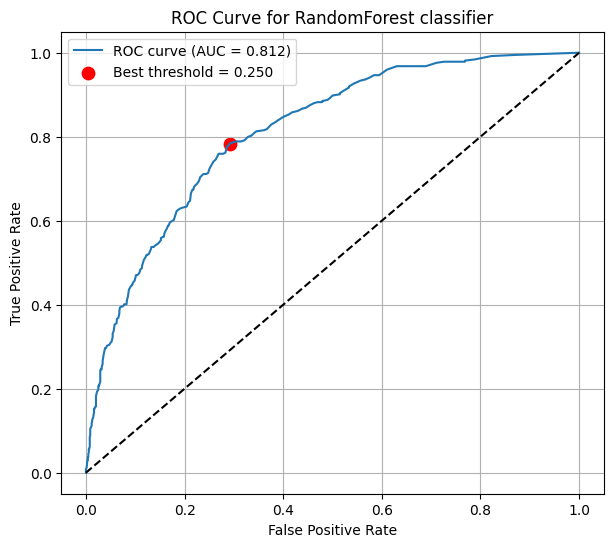

In [56]:
# Plot the ROC curve and mark the best threshold
plt.figure(figsize=(7, 6))

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.3f})')

# Plot the best threshold point
plt.scatter(fpr[ix], tpr[ix], color='red', s=80,
            label=f'Best threshold = {best_thresh:.3f}')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for RandomForest classifier")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# store model metrics for comparison with other models
rf_metrics = evaluate_model('RandomForest', y_test, churn_pred, y_proba)

#### Gradient Boosting

In [58]:
# Tree-based model: Gradient Boosting

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=0
)

gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [59]:
# To get the probabilities we use the predict_proba of the model. The result is a matrix with two columns. 
# The first column contains the probability that the target variable is zero (the client won't churn). The 
# second column contains the probability that the target is positive (the client will churn). 
y_proba = gb_model.predict_proba(X_test)[:, 1]
y_proba.shape 

(1407,)

In [60]:
# Convert model probabilities into class predictions

# If the probability for a customer is higher than a threshold, we predict churn, otherwise not
# churn. We will use 0.5 as the threshold:
churn_pred = (y_proba >= 0.5).astype(int) 

In [61]:
# compute the accuracy score for the model
accuracy = accuracy_score(y_test, churn_pred)

print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.79


In [62]:
# loop over different thresholds and check which one gives the best accuracy
thresholds = np.linspace(0, 1, 11)
accuracies = []

for t in thresholds:
    churn = y_proba >= t
    acc = accuracy_score(y_test, churn)
    print('%0.2f %0.3f' % (t, acc))
    accuracies.append(acc)

0.00 0.266
0.10 0.648
0.20 0.711
0.30 0.747
0.40 0.773
0.50 0.787
0.60 0.780
0.70 0.776
0.80 0.768
0.90 0.756
1.00 0.734


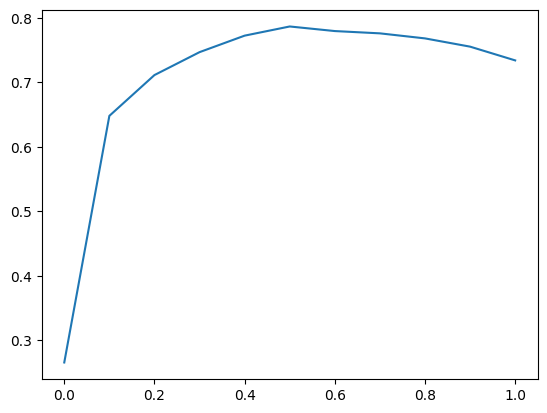

In [63]:
plt.plot(thresholds, accuracies)

If a prediction is higher than the threshold we predict 'churn', otherwise we predict 'no churn'. The best threshold is 0.5, and the best accuracy we can achieve for the model is 0.785 (79%).

In [64]:
# Calculate a confusion matrix to get a detailed breakdown of the model’s performance compared to the actual values
conf_matrix = confusion_matrix(y_test, churn_pred)
print(f"Confusion Matrix: \n{conf_matrix}") 

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

print (f"tp: {tp}")
print (f"tn: {tn}")
print (f"fp: {fp}")
print (f"fn: {fn}")

Confusion Matrix: 
[[918 115]
 [185 189]]
tp: 189
tn: 918
fp: 115
fn: 185


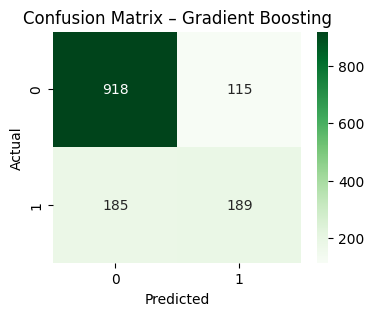

In [65]:
# Confusion matrix for Gradient Boosting

# Show confusion matrix for Logistic Regression
cm_gb = confusion_matrix(y_test, churn_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Greens") 
plt.title("Confusion Matrix – Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [66]:
# calculate model precision
# precision tells us how many customers actually churned out of all those we predicted would churn (tp + fp) ?
 
P = tp / (tp + fp) 
print(f"Precision: {round(P, 3)}")

Precision: 0.622


In [67]:
# calculate recall
# recall tells us the percentage of customers correctly predicted as churning out of all churned customers (tp + fn) 
R = tp / (tp + fn) 
print(f"Recall: {round(R, 3)}")

Recall: 0.505


For the GradientBoosting model the precision is 62% and the recall is 51%. The precision of 62% means that 62% of the customers we identified as going to churn actually churned (true positives) whereas 38% of the customers we identified as going to churn did not churn (false positives). The recall of 51% means that we identified only 51% of all churning users (true positives) and failed to identify the remaining 49% (false negatives).

In [68]:
# Calculate the False Positive Rate (fpr), True Positive Rate (tpr) and the Area Under Curve (auc) and plot 
# a ROC curve for the GradientBoosting Model 

# y_test = true labels (0/1)
# y_proba = predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc  = auc(fpr,  tpr)  

In [69]:
# Find the best threshold for the ROC curve
# Compute Youden J index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best Threshold:", best_thresh)
print("TPR:", tpr[ix], "FPR:", fpr[ix])

Best Threshold: 0.2433737640360117
TPR: 0.7620320855614974 FPR: 0.27299128751210067


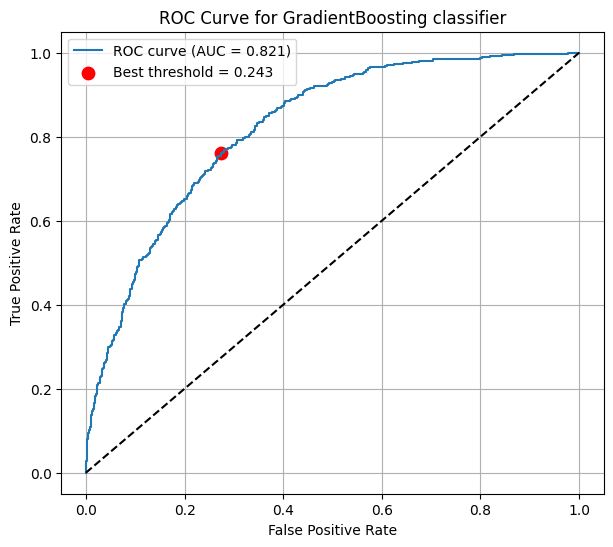

In [70]:
# Plot the ROC curve and mark the best threshold
plt.figure(figsize=(7, 6))

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.3f})')

# Plot the best threshold point
plt.scatter(fpr[ix], tpr[ix], color='red', s=80,
            label=f'Best threshold = {best_thresh:.3f}')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for GradientBoosting classifier")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# store model metrics for comparison with other models
gb_metrics = evaluate_model('GradientBoosting', y_test, churn_pred, y_proba) 

#### Model Comparison

In [72]:
# Compare model metrics

metrics_df = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)

for metrics in [lr_metrics, rf_metrics, gb_metrics]:
    new_row = metrics[["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]]
    metrics_df.loc[len(metrics_df)] = new_row.loc[0]  
    
metrics_df.index = ["Logistic Regression", "Random Forest", "Gradient Boosting"]

metrics_df

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.788202,0.622581,0.516043,0.564327,0.832112
Random Forest,0.784648,0.626335,0.470588,0.537405,0.811871
Gradient Boosting,0.786780,0.621711,0.505348,0.557522,0.821490


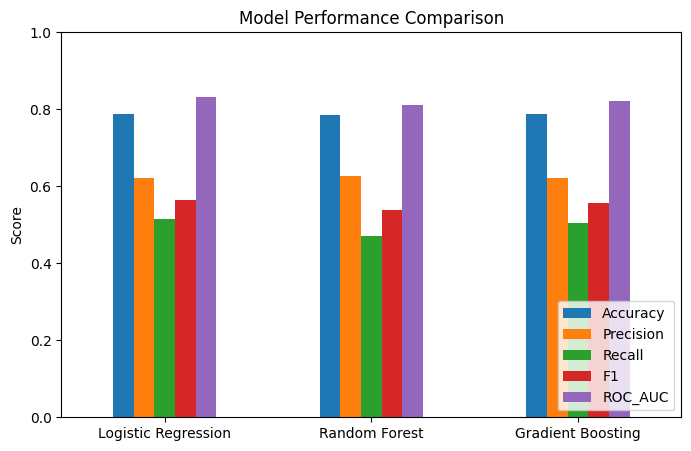

In [73]:
# Simple bar plot comparison

metrics_df.plot(kind="bar", figsize=(8, 5))
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()

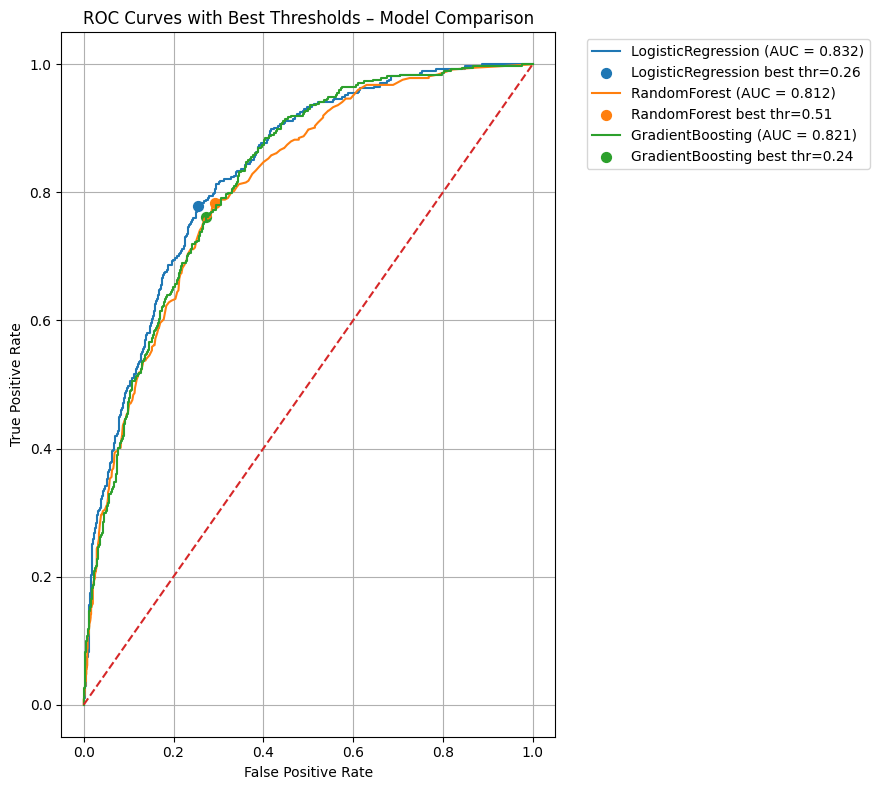

In [74]:
# Plot ROC curves with best thresholds - model comparison

plt.figure(figsize=(9, 8))

for model_metrics in [lr_metrics, rf_metrics, gb_metrics]:
    
    name, fpr, tpr, auc = model_metrics[['Name','FPR', 'TPR', 'ROC_AUC']].iloc[0]  
    
    # Best threshold using Youden J
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.scatter(fpr[ix], tpr[ix], s=50,
                label=f"{name} best thr={best_thresh:.2f}")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Best Thresholds – Model Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Findings

The Telco churn dataset has 7032 customer records out of which 73% did not churn and 27% churned. In an unbalanced binary classification like this accuracy metrics can be misleading. The model may achieve high accuracy simply by predicting the majority class (negatives in this scenario) for most or all instances, while failing to identify the minority class (positives). Because accuracy is an unreliable metric for unbalanced datasets, we use alternative metrics that provide a more comprehensive view of the model's performance. 

- Confusion Matrix: The confusion matrix separates true positives, true negatives, false positives and false negatives.

- Precision: From the confusion matrix we calculate precision. Precision measures the accuracy of positive predictions. It tells us how many of the predicted positives were actually positive.

- Recall (Sensitivity): We also calculate Recall from the confusion matrix. Recall measures the ability to find all actual positive instances. It tells us how many of the actual positives were captured by the model.

- F1-Score: The harmonic mean of precision and recall. This score provides a balanced measure when both precision and recall are important. 

- Area under the ROC curve (AUC): The area under the ROC curve summarizes a model's ability to distinguish between positive and negative classes. It is a single metric for overall performance. A higher AUC indicates better discrimination with 1.0 being perfect and 0.5 being useless. 

In this study we compared the performance of three classification models: Logistic Regression, Random Forest and Gradient Boosting. When we compare the Accuracy, Precision, Recall, F1-Score and ROC AUC for the three models we conclude that overall the models' performance was okay but not highly accurate. The best accuracy we obtained was 0.79 and the best AUC metrics was 0.83. An AUC of 0.9 indicates a very good model and 0.7 indicates weak performance. The three models in our study had AUCs between 0.81 and  0.83. This shows us that the models are useful on this dataset but not highly accurate. It is likely with a larger dataset the accuracy of the models would improve. 

Of the three models, Logistic Regression performed the best. Its Accuracy, Precision, Recall, F1-Score and ROC AUC were all higher than the other models. The Random Forest model was the weakest model. It had a Recall score of only 0.47. The recall of 0.47 means that the model identified only 47% of all churning users (true positives) and failed to identify the remaining 53% (false negatives).

The Telco Churn dataset has many features but some are far more significant for predicting churn than others. When we evaluated the relative importance of the features we determined that Contract, OnlineSecurity, TechSupport, InternetService, OnlineBackup and PaymentMethod were the best predictors of churn. Of all the features the type of contract was by far the most significant. Customers with longer contracts of one or two years are less likely to churn than customers with month to month contracts. Interestingly, the second most important feature was OnlineSecurity. It appears from the data that having or not having online security makes a big difference as to whether customers leave or not. 
